In [11]:
import nltk
from nltk.corpus import stopwords 
stops = set(stopwords.words("english"))
from gensim.models import Word2Vec, Phrases
from bs4 import BeautifulSoup 
import re
import sqlite3
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import linear_model
import logging

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

#location of sqlite
dataLoc= './data/database.sqlite'

pd.set_option('max_colwidth', 100)

In [2]:
class Word2VecUtility(object):
    """Word2VecUtility is a utility class for processing raw HTML text into segments for further learning"""
    
    negators = [line.strip() for line in file('./data/negator.txt','r')]

    @staticmethod
    def review_to_wordlist( review, remove_stopwords=False ):
        # Function to convert a document to a sequence of words,
        # optionally removing stop words.  Returns a list of words.
        #
        # 1. Remove HTML
        review_text = BeautifulSoup(review, "lxml").get_text()
        #
        # 2. Extract special negator like n't
        review_text = re.sub('n\'t', ' not', review_text)
        #
        # 3. Remove non-letters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        #
        # 4. Convert words to lower case and split them
        words = review_text.lower().split()
        #
        # 5. Optionally remove stop words except for negators (false by default)
        if remove_stopwords:
            stops = set(stopwords.words("english"))
            words = [w for w in words if not w in stops or w in KaggleWord2VecUtility.negators]
        #
        # 6. Return a list of words
        return(words)

    # Define a function to split a review into parsed sentences
    @staticmethod
    def review_to_sentences( review, tokenizer, remove_stopwords=False ):
        # Function to split a review into parsed sentences. Returns a
        # list of sentences, where each sentence is a list of words
        #
        # 1. Use the NLTK tokenizer to split the paragraph into sentences
        raw_sentences = tokenizer.tokenize(review.encode('raw_unicode_escape').decode('utf8', 'replace').strip())
        #
        # 2. Loop over each sentence
        sentences = []
        for raw_sentence in raw_sentences:
            # If a sentence is empty, skip it
            if len(raw_sentence) > 0:
                # Otherwise, call review_to_wordlist to get a list of words
                sentences.append( Word2VecUtility.review_to_wordlist( raw_sentence, \
                  remove_stopwords ))
        #
        # Return the list of sentences (each sentence is a list of words,
        # so this returns a list of lists
        return sentences

In [3]:
connection = sqlite3.connect(dataLoc)
reviews = pd.read_sql_query(""" SELECT Score, Summary, Text FROM Reviews WHERE Score != 3 """, connection)

In [4]:
reviews.head()

,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of ...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted...
2,4,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelati..."
3,2,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got thi...
4,5,Great taffy,Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very qu...


In [5]:
reviews['word_list']=reviews['Summary'].apply(Word2VecUtility.review_to_wordlist)

C:\Anaconda2\lib\site-packages\bs4\__init__.py:198: UserWarning: "..." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  '"%s" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.' % markup)
C:\Anaconda2\lib\site-packages\bs4\__init__.py:207: UserWarning: "http://www.amazon.com/gp/product/B007I7YYGY/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.' % markup)
C:\Anaconda2\lib\site-packages\bs4\__init__.py:198: UserWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful S

In [6]:
print(reviews.head(10))

   Score                                        Summary  \
0      5                          Good Quality Dog Food   
1      1                              Not as Advertised   
2      4                          "Delight" says it all   
3      2                                 Cough Medicine   
4      5                                    Great taffy   
5      4                                     Nice Taffy   
6      5  Great!  Just as good as the expensive brands!   
7      5                         Wonderful, tasty taffy   
8      5                                     Yay Barley   
9      5                               Healthy Dog Food   

                                                                                                  Text  \
0  I have bought several of the Vitality canned dog food products and have found them all to be of ...   
1  Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted...   
2  This is a confection that has

In [ ]:
n_dim = 5000
model_name = "%dfeatures_40minwords_10context" % n_dim
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences = []
for review in reviews['Text']:
    sentences += Word2VecUtility.review_to_sentences(review, tokenizer)
    
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
                            level=logging.INFO)

num_features = n_dim    # Word vector dimensionality
min_word_count = 5   # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

print "Training Word2Vec model..."
bigram_transformer = Phrases(sentences)
model = Word2Vec(bigram_transformer[sentences], workers=num_workers, \
                 size=num_features, min_count = min_word_count, \
                 window = context, sample = downsampling, seed=1)

model.init_sims(replace=True)
model.save(model_name)

In [3]:
n_dim = 5000
model_name = "%dfeatures_40minwords_10context" % n_dim
model = Word2Vec.load(model_name)
print "Creating the w2v vectors...\n"
model.most_similar('cookie', topn=20)

Creating the w2v vectors...



[(u'cookies', 0.7305686473846436),
 (u'brownie', 0.6963675022125244),
 (u'graham_cracker', 0.6502403020858765),
 (u'shortbread', 0.6094766855239868),
 (u'biscuit', 0.6075268983840942),
 (u'cracker', 0.5732108950614929),
 (u'fig_newton', 0.5687580108642578),
 (u'oreo', 0.5681439638137817),
 (u'wafer', 0.5678220391273499),
 (u'granola_bar', 0.5615130662918091),
 (u'graham_crackers', 0.5568894743919373),
 (u'candy_bar', 0.5347616076469421),
 (u'ginger_snap', 0.5297294855117798),
 (u'muffin', 0.5259690284729004),
 (u'wafers', 0.5253137946128845),
 (u'chocolate_chip', 0.525009274482727),
 (u'biscotti', 0.5204296112060547),
 (u'chips_ahoy', 0.5191755890846252),
 (u'ginger_snaps', 0.5151157975196838),
 (u'bar', 0.5105332136154175)]

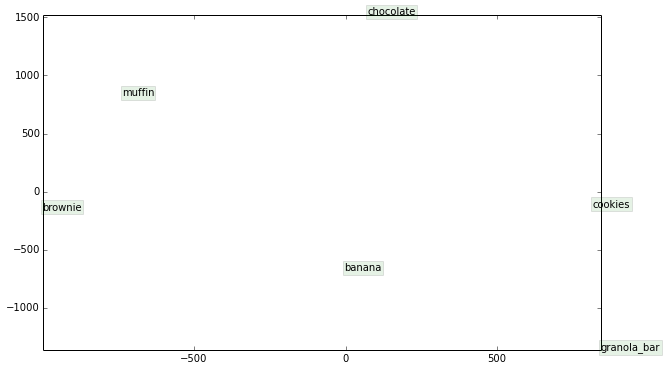

In [14]:
ignoredIndices = []
testTitles = ['cookies', 'chocolate', 'granola_bar', 'banana', 'brownie', 'muffin']
testVectors = []
for i, title in enumerate(testTitles):
    vectorWords = title.split(', ')
    result = None
    for vec in vectorWords:
        vec = vec.replace(' ', '_')
        try:
            if result is None:
                result = model[vec]
            else:
                result += model[vec]
        except:
            print "vector for word %s not found" % vec
    if result is None:
        ignoredIndices.append(i)
        testVectors.append([0] * 50)
    else:
        testVectors.append(result.tolist())
testVectorsArray = np.array(testVectors)

modelTSNE = TSNE(n_components=2, random_state=0)
X_2d = modelTSNE.fit_transform(testVectorsArray)
for i in xrange(len(testTitles)):
    if not i in ignoredIndices:
        plt.text(X_2d[i,0], X_2d[i,1], testTitles[i], bbox=dict(facecolor='green', alpha=0.1))
    
plt.xlim((np.min(X_2d[:,0]), np.max(X_2d[:,0])))
plt.ylim((np.min(X_2d[:,1]), np.max(X_2d[:,1])))

plt.show()